In [10]:
import numpy as np
import scipy.stats as st
import pandas as pd
import torch
import torch.distributions as td
from tqdm import tqdm
import random

from agents.base_agent import Agent
from agents.bayesian_agent import BayesianAgent
from plotting import plot_simulation_stats, plot_learned_distribution_matrix, plot_communication_network

### RBPC with Intruders

In [11]:
def reproduce(population: list[Agent], mu: float, reputation=False, size=1):
    offspring = []
    if reputation:
        if len(population) > 2:
            total_rep = np.sum([agent.reputation for agent in population])
            repr_chances = td.Categorical(probs=torch.Tensor([agent.reputation/total_rep for agent in population])) # agents with higher reputation have higher chances of reproduction
            for _ in range(size):
                parent1 = population[int(repr_chances.sample())]
                while True:
                    parent2 = population[int(repr_chances.sample())]
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    else:
        if len(population) > 2:
            for _ in range(size):
                parent1 = random.choice(population)
                while True:
                    parent2 = random.choice(population)
                    if parent1 != parent2:
                        break
                offspring.append(Agent(mu, parents=(parent1, parent2)))
    return offspring


def simulate_bio_evolution(num_food_opportunities: int, num_generations:int, population_size:int, reputation_reproduction: bool, intruders=False, mu=0.01, partitions=2, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)

    # set up df to collect data:
    features = pd.DataFrame(columns=["generation", "feature", "type", "starvation"])
    partitions = [round(i/partitions*num_generations) for i in range(partitions+1)]
    partitions[0] = 1   
    #initialize first generation
    current_gen = [Agent(mu) for _ in range(population_size)]

    for gen in tqdm(range(1, (num_generations+1))):
        if intruders and (gen in partitions[1:]):
            for agent in current_gen[10:20]:
                agent.malintent = 15
                agent.id = "intruder"
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(current_gen))

            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent = [],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
        features.loc[len(features.index)] = [gen, np.mean(communication) if len(current_gen) > 0 else None, "communication", (population_size-len(current_gen))]
        features.loc[len(features.index)] = [gen, np.mean(malintent) if len(current_gen) > 0 else None, "malintent", (population_size-len(current_gen))]

        # simulate reproduction with reputation:
        current_gen = reproduce(current_gen, mu, reputation=reputation_reproduction, size=population_size)
    return features, partitions if intruders else features

100%|██████████| 200/200 [11:11<00:00,  3.36s/it]


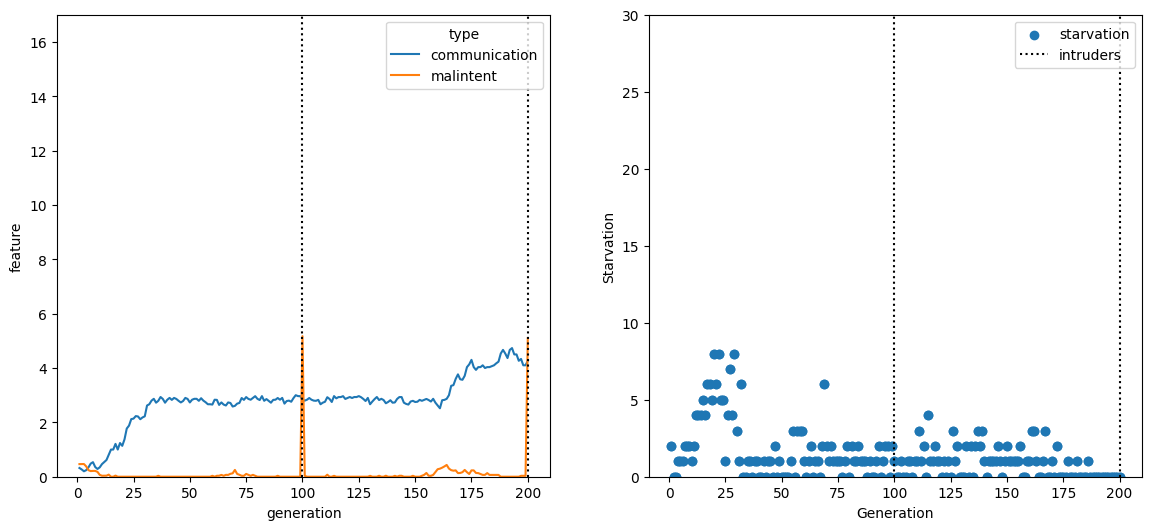

In [12]:
sim_bio, intruders = simulate_bio_evolution(num_food_opportunities=100, num_generations=200, population_size=30, intruders=True, reputation_reproduction=True, food_decay=1.65)
plot_bio = plot_simulation_stats(sim_bio, starvation_plot=True, intruders=intruders)

### Bayesian agents

In [13]:
def reproduce(population: list[BayesianAgent], mu: float, size=1):
    offspring = []
    if len(population) > 2:
        for _ in range(size):
            while True:
                parent1 = random.choice(population)
                parent2 = random.choice(parent1.cohort)
                if st.bernoulli(parent1.likelihood_communicate(parent2)).rvs(1) and st.bernoulli(parent2.likelihood_communicate(parent1)).rvs(1):
                    offspring.append(BayesianAgent(mu, parents=(parent1, parent2)))
                    break
    return offspring

def simulate_bayesian_agents(num_food_opportunities: int, num_generations:int, population_size:int, gossip=False, intruders=False, mu=0.01, partitions=2, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)
    # set up df to collect data:
    features = pd.DataFrame(columns=["generation", "feature", "type", "starvation"])
    # initialize first generation
    current_gen = [BayesianAgent(mu) for _ in range(population_size)]
    # for saving data about bayesian updating
    partitions = [round(i/partitions*num_generations) for i in range(partitions+1)]
    partitions[0] = 1
    saved_generations = {} # generation: list of agents
    for gen in tqdm(range(1, (num_generations+1))):
        if intruders and (gen in partitions[1:]):
            for i, agent in enumerate(current_gen[10:20], 1):
                agent.malintent = 15
                agent.id = f"intruder_{i}"
        for agent in current_gen:
            agent.set_cohort(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(agent.cohort))
                # incorporate gossip (exchange of information)
                if gossip:
                    if len(agent.last_interaction) == 2:
                        other, pos_outcome = agent.last_interaction
                        recipient = np.random.choice(agent.cohort)
                        if other is not recipient:
                            recipient.incorporate_gossip(agent, other, pos_outcome)
            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent, reputation = [], [], []
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
            reputation.append(agent.reputation)
        features.loc[len(features.index)] = [gen, np.mean(communication) if len(current_gen) > 0 else None, "communication", (population_size-len(current_gen))]
        features.loc[len(features.index)] = [gen, np.mean(malintent) if len(current_gen) > 0 else None, "malintent", None]
        if gen in partitions:
            saved_generations[gen] = [agent for agent in current_gen]

        # simulate reproduction with reputation:
        if gen < num_generations:
            current_gen = reproduce(current_gen, mu, size=population_size)
    return (saved_generations, features, partitions) if intruders else (saved_generations, features)

100%|██████████| 200/200 [14:38<00:00,  4.39s/it]


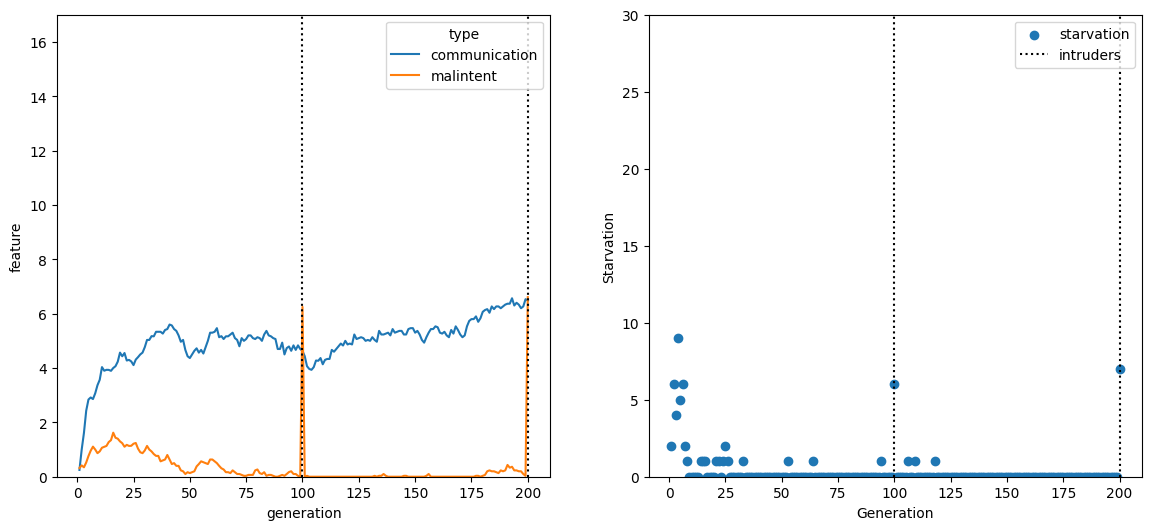

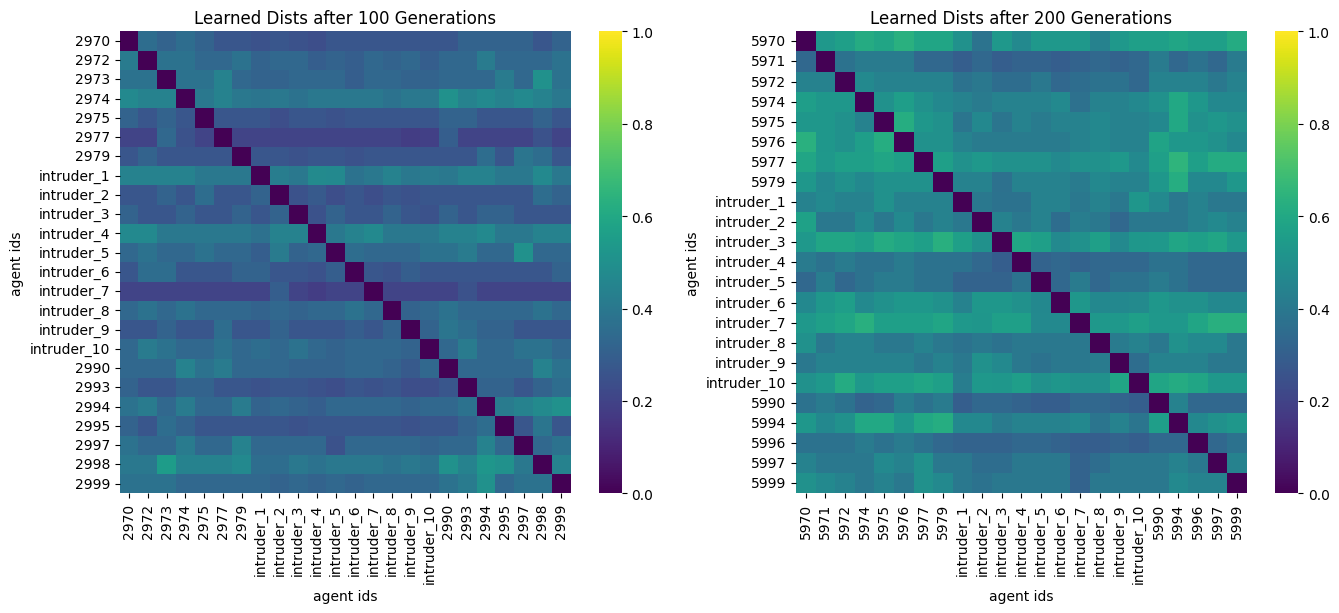

In [14]:
no_gossip_gens, bayes_no_gossip, intruders = simulate_bayesian_agents(num_food_opportunities=100, num_generations=200, population_size=30, intruders=True, food_decay = 1.65)
plot_no_gossip = plot_simulation_stats(bayes_no_gossip, starvation_plot=True, intruders=intruders)
matrix_no_gossip = plot_learned_distribution_matrix(no_gossip_gens, intruder=True, figsize=(16,6))

100%|██████████| 200/200 [22:02<00:00,  6.61s/it] 


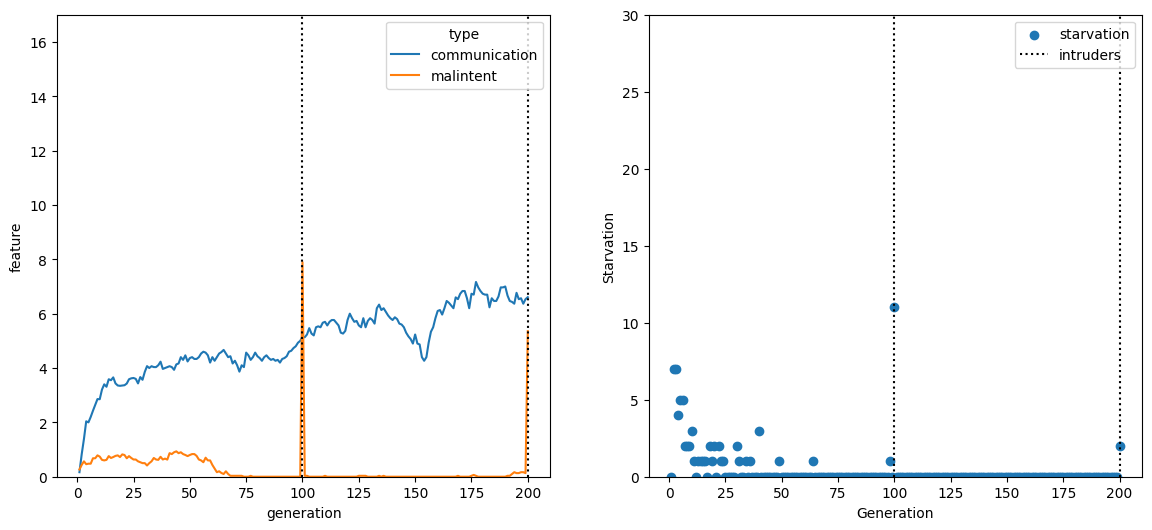

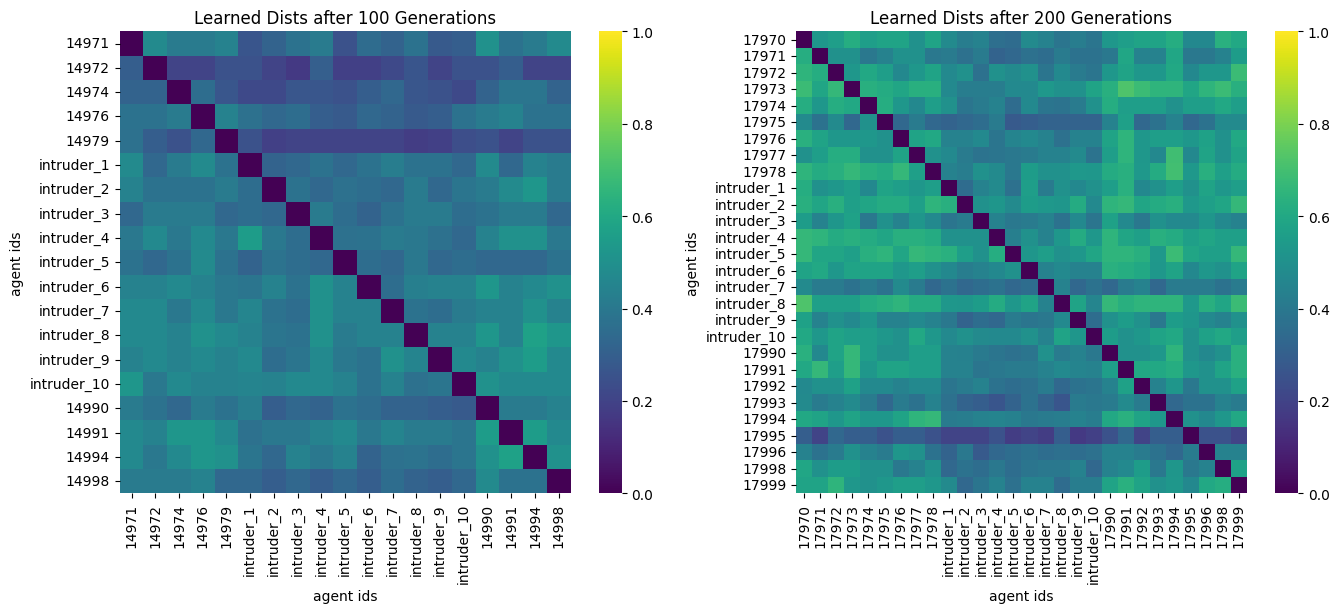

In [16]:
gossip_gens, bayes_gossip, intruders = simulate_bayesian_agents(num_food_opportunities=100, num_generations=200, population_size=30, gossip=True, intruders=True, food_decay = 1.65)
plot_gossip = plot_simulation_stats(bayes_gossip, starvation_plot=True, intruders=intruders)
matrix_gossip = plot_learned_distribution_matrix(gossip_gens, intruder=True, figsize=(16,6))